In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
MinMax = MinMaxScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats

In [2]:
#수원시 온도 데이터 호출
Tem_File_read = pd.read_csv("제주기상데이터.csv", encoding='cp949').reset_index(drop = True)
Tem_File_read['일시'] = pd.to_datetime(Tem_File_read['일시'])
Tem_File_read = Tem_File_read.drop(columns='지점명')
Tem_File_read = Tem_File_read.drop(columns='지점')
Tem_File_read = Tem_File_read.drop(columns='강수량(mm)')
Tem_File_read = Tem_File_read.drop(columns='일사(MJ/m2)')
Tem_File_read['기온(°C)'] = Tem_File_read['기온(°C)'].interpolate(method='polynomial', order=1)
Tem_File_read['풍향(16방위)'] = Tem_File_read['풍향(16방위)'].interpolate(method='polynomial', order=1)
Tem_File_read['습도(%)'] = Tem_File_read['습도(%)'].interpolate(method='polynomial', order=1)
Tem_File_read['이슬점온도(°C)'] = Tem_File_read['이슬점온도(°C)'].interpolate(method='polynomial', order=1)
Tem_File_read['현지기압(hPa)'] = Tem_File_read['현지기압(hPa)'].interpolate(method='polynomial', order=1)
Tem_File_read =Tem_File_read.drop(0, axis = 0)

Tem_File_read.reset_index(inplace=True)
print(Tem_File_read)


      index                  일시  기온(°C)  풍향(16방위)  습도(%)  이슬점온도(°C)  \
0         1 2023-01-01 01:00:00     5.4     230.0   65.0       -0.6   
1         2 2023-01-01 02:00:00     5.3     230.0   64.0       -0.9   
2         3 2023-01-01 03:00:00     5.4     230.0   65.0       -0.6   
3         4 2023-01-01 04:00:00     5.9     230.0   65.0       -0.1   
4         5 2023-01-01 05:00:00     6.2     250.0   65.0        0.0   
...     ...                 ...     ...       ...    ...        ...   
6547   6548 2023-09-30 20:00:00    21.4      20.0   71.0       15.9   
6548   6549 2023-09-30 21:00:00    21.3      20.0   72.0       16.0   
6549   6550 2023-09-30 22:00:00    21.3      20.0   76.0       16.8   
6550   6551 2023-09-30 23:00:00    21.1      20.0   78.0       17.1   
6551   6552 2023-10-01 00:00:00    20.9     360.0   78.0       16.9   

      현지기압(hPa)  전운량(10분위)  지면온도(°C)  
0        1029.7          3       3.3  
1        1029.5          5       3.0  
2        1029.1          4    

In [3]:
Tem_File_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      6552 non-null   int64         
 1   일시         6552 non-null   datetime64[ns]
 2   기온(°C)     6552 non-null   float64       
 3   풍향(16방위)   6552 non-null   float64       
 4   습도(%)      6552 non-null   float64       
 5   이슬점온도(°C)  6552 non-null   float64       
 6   현지기압(hPa)  6552 non-null   float64       
 7   전운량(10분위)  6552 non-null   int64         
 8   지면온도(°C)   6552 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 460.8 KB


In [4]:
#데이터셋 생성
df = pd.read_csv("C:/Users/hy913/Samdasu_Forecasting/제주특별자치도개발공사_제주삼다수공장 시간별 전력사용량_20230930.csv", header=None, encoding='cp949').reset_index(drop = True)
df.drop(0)
df = df.drop(0, axis=1)
df = np.ravel(df, order='C')
df = pd.DataFrame(df)
df = df.drop(range(0, 24))
df = df.reset_index(drop=True)
data = pd.DataFrame()
date = pd.date_range("2023-01-01 01:00:00", "2023-10-01 00:00:00", freq='1h')
data['date'] = date
data['usage'] = df

#공휴일 데이터셋 생성
kr_holidays = holidays.KR()
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(date)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0) #공휴일은 1, 그렇지 않으면 0

data2 = pd.concat([data, Tem_File_read], axis = 1)
data2 = data2.drop('일시', axis = 1)
data2 = data2.drop('index', axis = 1)

data['is_holiday'] = holiday_df['holiday']
data['weekday'] = data['date'].dt.weekday
#dummy = pd.get_dummies(data['weekday'])
#data = pd.concat([data, dummy],  axis = 1)
#data = data.astype({'Friday':'int',	'Monday':'int',	'Saturday':'int',	'Sunday':'int',	'Thursday':'int',	'Tuesday':'int',	'Wednesday':'int'})

data

,date,usage,is_holiday,weekday
0,2023-01-01 01:00:00,6481,1,6
1,2023-01-01 02:00:00,6409,1,6
2,2023-01-01 03:00:00,7086,1,6
3,2023-01-01 04:00:00,7042,1,6
4,2023-01-01 05:00:00,7136,1,6
...,...,...,...,...
6547,2023-09-30 20:00:00,733,1,5
6548,2023-09-30 21:00:00,739,1,5
6549,2023-09-30 22:00:00,734,1,5
6550,2023-09-30 23:00:00,739,1,5


In [5]:
data2

,date,usage,기온(°C),풍향(16방위),습도(%),이슬점온도(°C),현지기압(hPa),전운량(10분위),지면온도(°C)
0,2023-01-01 01:00:00,6481,5.4,230.0,65.0,-0.6,1029.7,3,3.3
1,2023-01-01 02:00:00,6409,5.3,230.0,64.0,-0.9,1029.5,5,3.0
2,2023-01-01 03:00:00,7086,5.4,230.0,65.0,-0.6,1029.1,4,2.9
3,2023-01-01 04:00:00,7042,5.9,230.0,65.0,-0.1,1028.7,4,3.2
4,2023-01-01 05:00:00,7136,6.2,250.0,65.0,0.0,1028.3,5,3.4
...,...,...,...,...,...,...,...,...,...
6547,2023-09-30 20:00:00,733,21.4,20.0,71.0,15.9,1009.6,4,21.4
6548,2023-09-30 21:00:00,739,21.3,20.0,72.0,16.0,1009.8,7,20.7
6549,2023-09-30 22:00:00,734,21.3,20.0,76.0,16.8,1010.2,4,20.6
6550,2023-09-30 23:00:00,739,21.1,20.0,78.0,17.1,1010.7,3,20.2


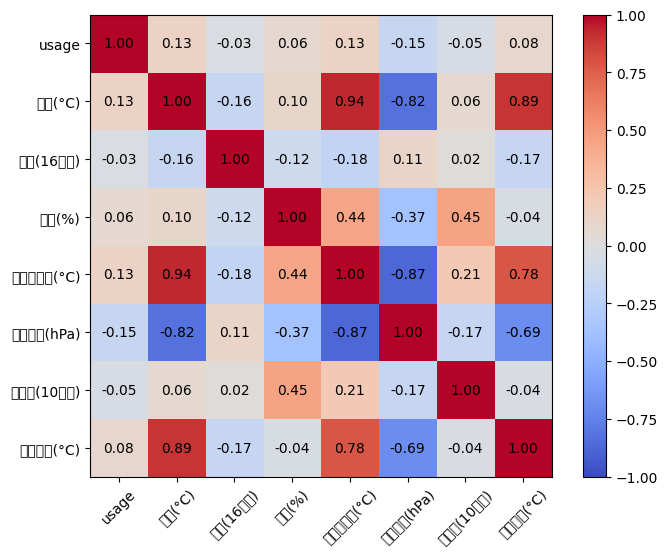

In [6]:
data2 = data2.drop('date', axis = 1)
import seaborn as sns
import matplotlib.pyplot as plt

# iris 데이터셋 로드


# 상관 관계 계산
corr_matrix = data2.corr()

# Heatmap으로 상관 관계 표시
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# x, y 축 눈금 설정
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# 주석 추가
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = "{:.2f}".format(corr_matrix.iloc[i, j])
        plt.annotate(text, xy=(j, i), ha='center', va='center')

# 컬러바 추가
plt.colorbar()

# 그래프 출력
plt.show()

#상관관계가 없어 기상관련 데이터 사용 X

In [7]:
#data.to_csv("C:/Users/hy913/Downloads/삼다수 공장 전력 사용량.csv")

In [8]:
past_history = 24*3
future_target = 1
STEP = 1
predict_col = 0

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, target_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [10]:
def preprocessing(data, past_history, future_target, STEP, predict_col):

    TRAIN_SPLIT = int(len(data)* 0.8)

    features_considered = ['usage', 'is_holiday', 'weekday'] # , 'Friday',	'Monday',	'Saturday',	'Sunday',	'Thursday',	'Tuesday',	'Wednesday'
    features = data[features_considered]
    features.index = data['date']
    #features.plot(subplots=True)

    dataset = features.values
    MinMax.fit(dataset)
    dataset = MinMax.transform(dataset)
    print(dataset)

    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)
    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)

    return x_train_multi, y_train_multi, x_val_multi, y_val_multi

In [11]:
x_train_multi, y_train_multi, x_val_multi, y_val_multi = preprocessing(data, past_history, future_target, STEP, predict_col)



[[0.68690306 1.         1.        ]
 [0.67899879 1.         1.        ]
 [0.75332089 1.         1.        ]
 ...
 [0.05598858 1.         0.83333333]
 [0.05653749 1.         0.83333333]
 [0.05675705 0.         1.        ]]


In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 10
EPOCHS = 10
EVALUATION_INTERVAL = len(x_train_multi)//BATCH_SIZE
VALIDATION_STEPS = len(x_val_multi)//BATCH_SIZE # if you have validation data 

In [13]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [14]:
#TRAIN_SPLIT = int(len(df)* 0.8) #총 데이터 길이가 16272 그 중 약 80%
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [15]:
def create_time_steps(length):
  return range(-length, 0)

In [16]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  
  plt.plot(num_in, np.array(history[:, predict_col]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

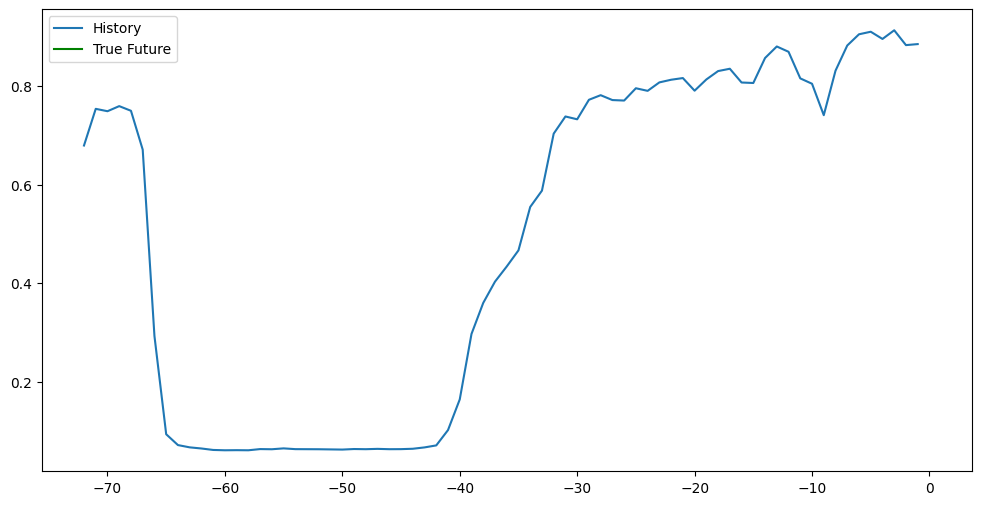

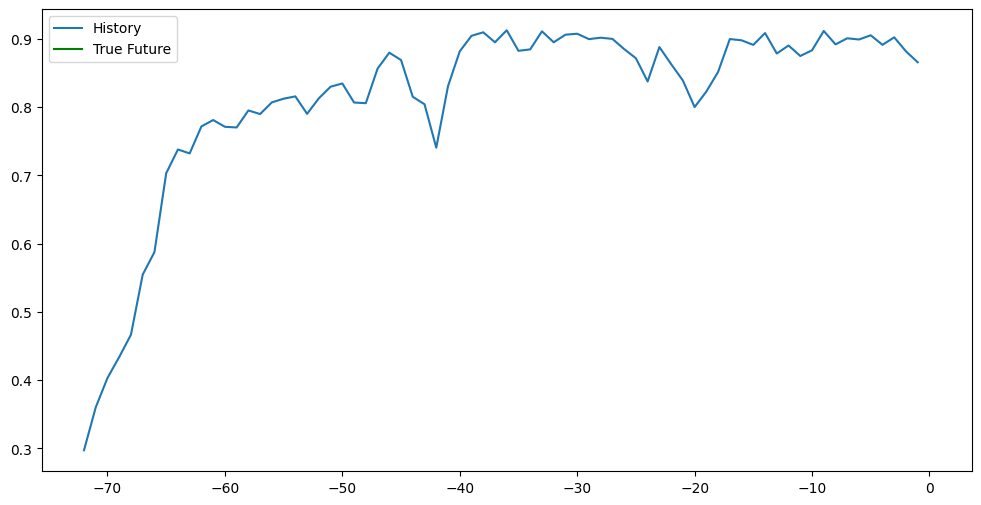

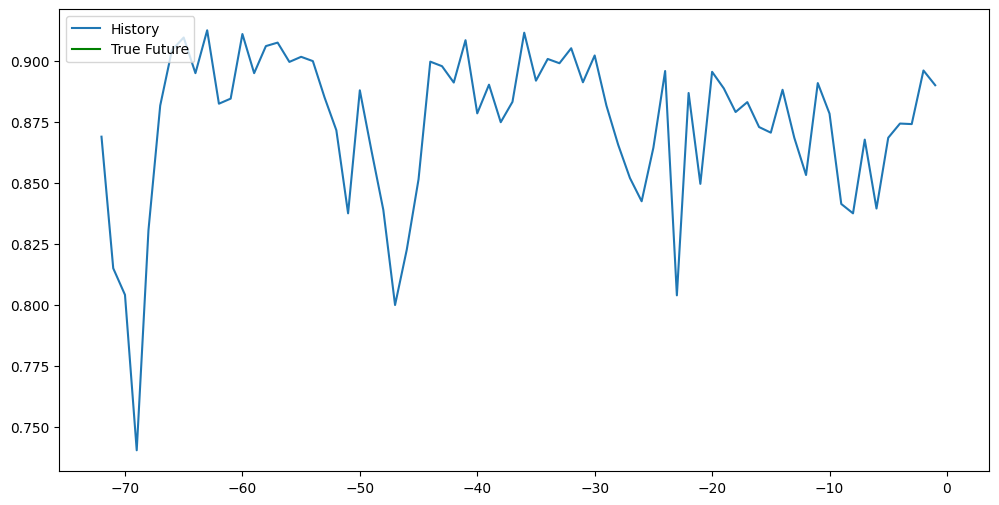

In [17]:
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))

In [18]:
from torch import nn, optim
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [19]:
epochs = 50

validation = 0.1

In [20]:
x_val_multi.shape

(1238, 72, 3)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='mae', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
DATA_OUT_PATH = '/One_energy/'
model_name = 'two_lstm'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='mae', verbose=1, save_best_only=True, save_weights_only=True)

/One_energy/two_lstm -- Folder already exists 



In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Attention
from keras.layers import concatenate

In [23]:
adam = optimizers.Adam(lr = 0.001)

In [24]:

input1 = Input(shape=x_train_multi.shape[-2:])
dense1 = Conv1D(filters=16, kernel_size = 1, activation='relu')(input1)
dense1_2 = Conv1D(filters=32, kernel_size = 1, activation='relu')(dense1)
dense1_3 = Conv1D(filters= 64, kernel_size = 1, activation='relu')(dense1_2)
dense1_4 = Flatten()(dense1_3)
#dense1_5 = BatchNormalization()(dense1_4)

input2 = Input(shape=x_train_multi.shape[-2:])
dense2 = LSTM(16, return_sequences=True)(input2)
dense2_2 = LSTM(32, return_sequences=True)(dense2)
dense2_3 = LSTM(64, return_sequences=False)(dense2_2)
#dense2_4 = BatchNormalization()(dense2_3)

from keras.layers import concatenate

merge1 = concatenate([dense1_4, dense2_3])

#drop_out = Dropout(0.3)(merge1)

#model1 = BatchNormalization()(merge1)
#model3 = Flatten()(model1)
model2 = Dense(64)(merge1)
model3 = Dense(32)(model2)
output = Dense(1)(model3)

In [25]:
model = Model(inputs = [input1, input2], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 72, 16)       64          ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 72, 3)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 72, 32)       544         ['conv1d[0][0]']                 
                                                                                              

In [26]:
model.compile(optimizer=adam, loss='mae', metrics=['mae'])

model_history=model.fit([x_train_multi, x_train_multi], y_train_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          #validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS, 
                                          batch_size = 64, callbacks=[earlystop_callback, cp_callback], validation_data=([x_val_multi, x_val_multi], y_val_multi))


Epoch 1/20
160/161 [============================>.] - ETA: 0s - loss: 0.0917 - mae: 0.0917WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 38 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: mae improved from inf to 0.09143, saving model to /One_energy/two_lstm\weights.h5
161/161 [==============================] - 6s 16ms/step - loss: 0.0914 - mae: 0.0914 - val_loss: 0.0689 - val_mae: 0.0689
Epoch 2/20
161/161 [==============================] - ETA: 0s - loss: 0.0419 - mae: 0.0419
Epoch 2: mae improved from 0.09143 to 0.04193, saving model to /One_energy/two_lstm\weights.h5
161/161 [==============================] - 2s 11ms/step - loss: 0.0419 - mae: 0.0419
Epoch 3/20
161/161 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.0374
Epoch 3: mae improved from 0.04193 to 0.03740, saving model to /One_

In [27]:
mae = model.evaluate([x_val_multi, x_val_multi], y_val_multi, batch_size = 1)

1238/1238 [==============================] - 5s 4ms/step - loss: 0.0414 - mae: 0.0414


In [28]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
from sklearn.metrics import r2_score
def RMSE(real, pred):
    return np.sqrt((1/len(real))* np.sum((real-pred)**2))

In [29]:
answer_list = []
predict_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, 72, 3))
    answer = y_val_multi[i]
    predict = model.predict([x, x])[0]
    answer_list.append(answer)
    predict_list.append(predict)

1/1 [==============================] - 0s 15ms/step


In [30]:
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1))

In [31]:
len(answer)

1238

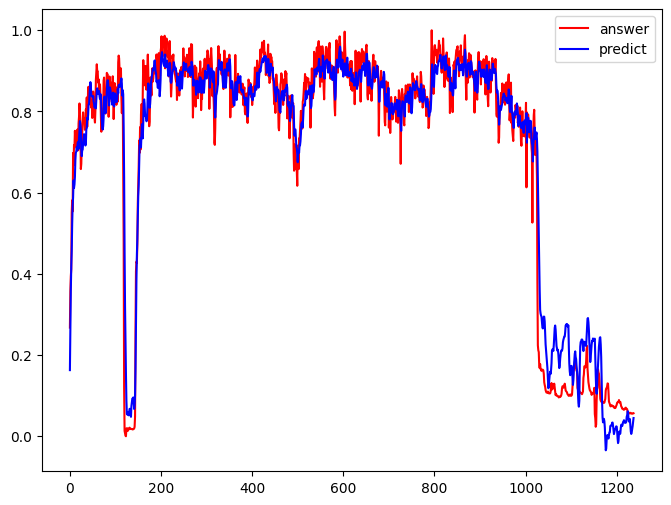

In [32]:
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')

plt.legend()
plt.show()

In [33]:
print(mae(answer, predict).numpy())
print(mse(answer, predict).numpy())
print(RMSE(answer, predict))
print(r2_score(answer, predict))


0.041385125
0.0037341684
0.06110784223518919
0.9605095377573655
